# Generating Models
This notebook demonstrates how to generate a model from a compact, string representation of the transcription factors for a gene. We refer to this as a *gene descriptor* or just *descriptor*.

There are 3 variants of descriptors, depending on the number of transcription factors:

- 0 TF: n. Example: "1". This is just the gene number. A "0" is used for INPUT.
- 1 TF: nsm. Example: "1+2". This indicates that P2 activates gene 1. "s" is sign, either "+" or "-".
- 2 TF: nsmisk. Example: "6+7O-1". This means that P7 activates Gene 6 or Gene 1 inhibits Gene 6. The "O" is a non-competitve OR integration term (or "i") and the "1" corresponds to "k" in the specification of this descriptor. Other integration terms are: "A" for AND and "P" for competitive OR integration.

In [1]:
%matplotlib inline
import tellurium as te
import gene_network as gn
import modeling_game as mg
import model_fitting as mf

import copy
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Creating Gene Reactions
This section is intended to give insight into how the code works. It is not essential for using the codes.

Network generation is done by constructing from each gene descriptor a reaction for the mRNA and a set of constants, some of which may need to be initialize.

In [2]:
# Create the reaction (including kinetics) for gene7
gene7 = gn.GeneReaction(7)
print(gene7)

J7: => mRNA7; L7 - d_mRNA7*mRNA7


In [3]:
result = gn.GeneReaction.do("7+4")
result.reaction

'J7: => mRNA7; L7 - d_mRNA7*mRNA7 + Vm7 * ( K1_7*P4^H7 ) / ( 1 + K1_7*P4^H7 )'

In [4]:
result.constants

['L7', 'd_mRNA7', 'K1_7', 'Vm7', 'H7']

In [5]:
result = gn.GeneReaction.do("7+4A-1")
result.reaction

'J7: => mRNA7; L7 - d_mRNA7*mRNA7 + Vm7 * ( K1_7*P4^H7 ) / ( 1 + K1_7*P4^H7 + K2_7*P1^H7 + K3_7*P4^H7*P1^H7 )'

## Creating and Using a Generated Model
Below are examples of running simulations using a network expressed in terms of gene descriptors, and a comparison between the simulation outputs of this representation and the original gene network.

In [6]:
# Descriptors for the initial network
print(gn.INITIAL_NETWORK)

['1+0O+4', '2+4', '3+6', '4-2', 5, '6+7A-1', 7, '8-1']


In [7]:
# Construct the network. Starts with INITIAL_NETWORK
network = gn.GeneNetwork()
# Generate the network
network.generate()

In [8]:
# network.generate() sets two properties in network. The first is the Antimony model.
print(network.model)



// Created by libAntimony v3.9.4

model *pathway()



  // Compartments and Species:

  species INPUT, P1, mRNA1, P2, mRNA2, P3, mRNA3, P4, mRNA4, P5, mRNA5, P6;

  species mRNA6, P7, mRNA7, P8, mRNA8;
J1: => mRNA1; L1 - d_mRNA1*mRNA1 + Vm1 * ( K1_1*INPUT^H1 + K2_1*P4^H1 + K3_1*INPUT^H1*P4^H1 ) / ( 1 + K1_1*INPUT^H1 + K2_1*P4^H1 + K3_1*INPUT^H1*P4^H1 )
J2: => mRNA2; L2 - d_mRNA2*mRNA2 + Vm2 * ( K1_2*P4^H2 ) / ( 1 + K1_2*P4^H2 )
J3: => mRNA3; L3 - d_mRNA3*mRNA3 + Vm3 * ( K1_3*P6^H3 ) / ( 1 + K1_3*P6^H3 )
J4: => mRNA4; L4 - d_mRNA4*mRNA4 + Vm4 * ( 1 ) / ( 1 + K1_4*P2^H4 )
J5: => mRNA5; L5 - d_mRNA5*mRNA5
J6: => mRNA6; L6 - d_mRNA6*mRNA6 + Vm6 * ( K1_6*P7^H6 ) / ( 1 + K1_6*P7^H6 + K2_6*P1^H6 + K3_6*P7^H6*P1^H6 )
J7: => mRNA7; L7 - d_mRNA7*mRNA7
J8: => mRNA8; L8 - d_mRNA8*mRNA8 + Vm8 * ( 1 ) / ( 1 + K1_8*P1^H8 )

// Initializations for new constants




  

// Protein Reactions:

  F1:  => P1; a_protein1*mRNA1 - d_protein1*P1;

  F2:  => P2; a_protein2*mRNA2 - d_protein2*P2;

  F3:  => P

In [9]:
# The second is the lmfit.Parameters() needed for parameter optimization
network.parameters

name,value,initial value,min,max,vary
L1,0.02000000,0.02,0.01000000,0.03000000,True
L2,0.02000000,0.02,0.01000000,0.03000000,True
K1_6,0.02000000,0.02,0.01000000,0.03000000,True
K3_6,0.02000000,0.02,0.01000000,0.03000000,True
K1_2,0.02000000,0.02,0.01000000,0.03000000,True
H2,5.00000000,5.0,2.00000000,8.00000000,True
H8,5.00000000,5.0,2.00000000,8.00000000,True
K1_3,0.02000000,0.02,0.01000000,0.03000000,True
K1_8,0.02000000,0.02,0.01000000,0.03000000,True
d_mRNA5,1.25000000,1.25,0.50000000,2.00000000,True


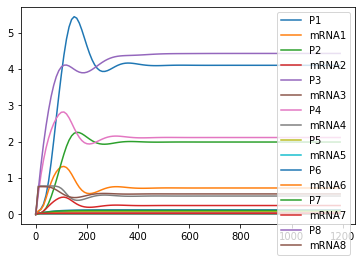

In [10]:
# Here's the result of simulating the generated network
rr = te.loada(network.model)
data = rr.simulate(0, 1200, 120)
df_data = mg.makeDF(data)
_ = plt.plot(df_data.index, df_data)
_ = plt.legend(df_data.columns)

In [11]:
def simulateInitialModel():
    """
    Simulates the original model. Returns a dataframe of the result with just mRNA.
    """
    with open("initial-Antimony-model.txt", "r") as fd:
        initial_model = fd.readlines()
    model = "".join(initial_model)
    rr = te.loada(model)
    data = rr.simulate(0, 1200, 120)
    return mg.makeDF(data)

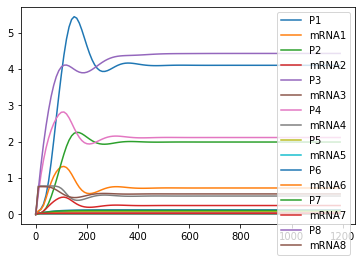

In [12]:
# Compare the above results with the file initial-Antimony-model.txt
df_initial = simulateInitialModel()
_ = plt.plot(df_initial.index, df_initial)
_ = plt.legend(df_data.columns)

In [13]:
df = df_initial - df_data
df.sum().sum()

4.992247934487715e-13

## Using Generated Networks in Network Discovery

In [14]:
# Observed data
# mRNA data for wild type
df_rnaseq = mf.cleanColumns(pd.read_csv("wild.csv"))
df_rnaseq.head()

,mRNA1,mRNA2,mRNA3,mRNA4,mRNA5,mRNA6,mRNA7,mRNA8
time,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10.0,0.099307,0.020844,0.007720,0.781444,0.013691,0.084857,2.404909,0.746052
20.0,0.129347,0.041853,0.007983,0.781449,0.014414,1.000481,2.361672,0.688322
30.0,0.241193,0.088704,0.055608,0.781449,0.065749,1.286064,2.248185,0.621902
40.0,0.436952,0.153115,0.357630,0.781445,0.282754,1.326094,2.102741,0.566512


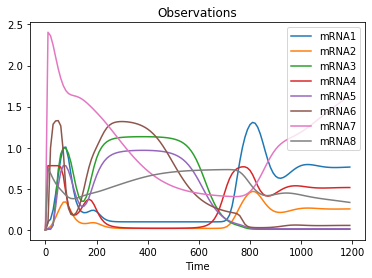

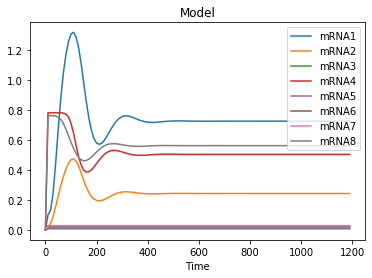

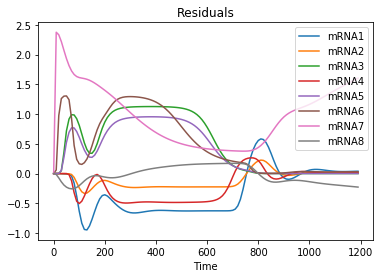

In [15]:
# Here's the result of simulating the generated networ
mg.plotSimulation(df_rnaseq, network.model)

In [16]:
# Default initial network
gn.INITIAL_NETWORK

['1+0O+4', '2+4', '3+6', '4-2', 5, '6+7A-1', 7, '8-1']

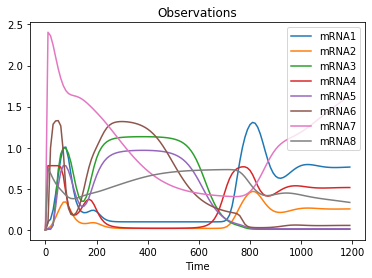

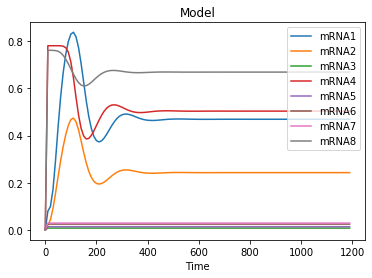

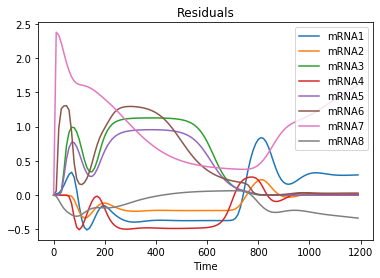

In [17]:
# Evaluating the initial model
network = gn.GeneNetwork()  # By default, uses the correct initial network
# Generate the network
network.generate()
# parameters = mg.runExperiment(df_rnaseq, network.model, network.parameters)
parameters = mg.runExperiment(df_rnaseq, network.model, ["Vm1"])

In [30]:
def evaluate(network, parameters, descriptors, sim_time=300):
    """
    Generates plots to evaluate the network using the parameters and descriptors.
    Only estimates the parameters for the new descriptors.
    :param GeneNetwork network:
    :param lmfit.Parameters parameters: parameters to use in constructing initializations
    :param list-str descriptors:
    :param int sim_time: length of the simululation
    :return GeneNetwork, lmfit.parameters:
    """
    new_network = network.copy()
    new_network.addInitialization(parameters)
    new_network.update(descriptors)
    # Generate the network
    new_network.generate()
    if len(new_network.new_parameters) == 0:
        news = "Vm1"
    else:
        news = new_network.new_parameters
    new_parameters = mg.makeParameters(news)
    # Just optimize the parameters that are initialized to 0, new_parameters
    newer_parameters = mg.runExperiment(df_rnaseq, new_network.model, new_parameters, 
                                      sim_time=sim_time)
    return new_network, newer_parameters

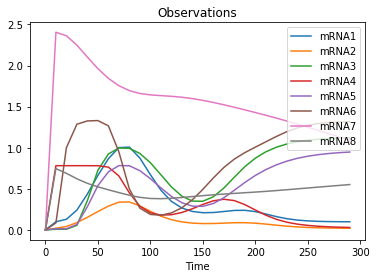

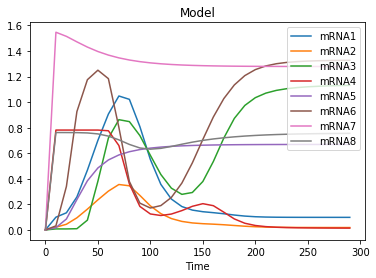

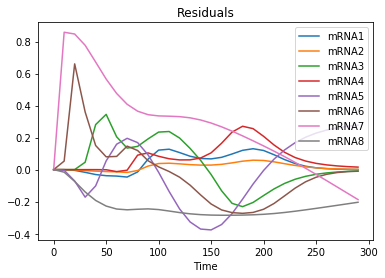

In [43]:
network = gn.GeneNetwork()  # By default, uses the correct initial network
network.update(['4-3','5+7','7-7'])
# Generate the network
network.generate()
# Just optimize the parameters that are initialized to 0, new_parameters
parameters1 = mg.runExperiment(df_rnaseq, network.model, network.new_parameters, 
                                  sim_time=300)

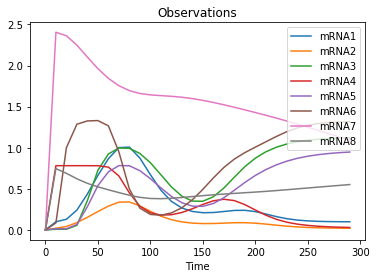

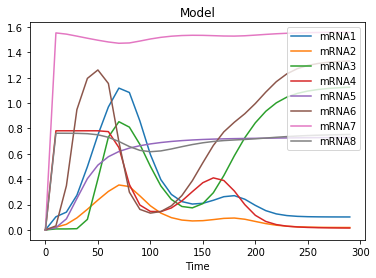

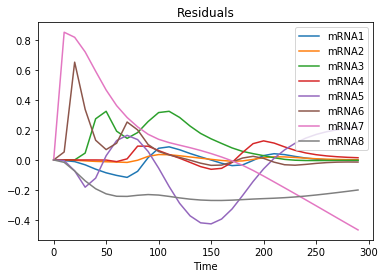

In [47]:
network2, parameters2 = evaluate(network, parameters1, ['7-4'], sim_time=300)

In [ ]:
new_network = network.copy()
new_network.addInitialization(parameters1)
new_network.update(['8+4A-8'])
new_network.generate()
# Just optimize the parameters that are initialized to 0, new_parameters
parameters2 = mg.runExperiment(df_rnaseq, new_network.model, new_network.new_parameters, 
                                  sim_time=100)

Challenges for iterative refinements

1. Cause and effect analysis of gene relationships
1. Noise
1. Sub-optimal parameter values (for efficiency) over a limited time period
1. Subjective objective function - quality of residuals